<a href="https://colab.research.google.com/github/athulrj02/DeepDuel/blob/main/ML%7CCA_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install tensorflow

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/MLPR Images'

In [5]:
# Verifying dataset path
if os.path.exists(dataset_path):
    print("Dataset path verified.")
else:
    print("Error: Dataset path not found!")

Dataset path verified.


In [6]:
# List files and directories in the dataset path
for root, dirs, files in os.walk(dataset_path):
  print(f"Found {len(dirs)} directories and {len(files)} files in '{root}'.")
  if dirs:
    print("Subdirectories:", dirs)
  if files:
    print("Example files:", files[:5])

Found 6 directories and 0 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images'.
Subdirectories: ['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5', 'Background']
Found 0 directories and 500 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_1'.
Example files: ['1500284916.jpg', '1500277597.jpg', '1500285311.jpg', '1500283844.jpg', '1500277274.jpg']
Found 0 directories and 14 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_2'.
Example files: ['1500276485.jpg', '1500276500.jpg', '1500276507.jpg', '1500276516.jpg', '1500276559.jpg']
Found 0 directories and 400 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_3'.
Example files: ['1500275183.jpg', '1500275458.jpg', '1500275226.jpg', '1500275336.jpg', '1500275563.jpg']
Found 0 directories and 385 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_4'.
Example files: ['1500285823.jpg', '1500286036.jpg', '1500285981.jpg', '1500286329.jpg', '

In [7]:
# !pip install tensorflow numpy matplotlib opencv-python scikit-learn

Analyzing Dataset and Checking Class Distribution

In [8]:
import cv2
from collections import Counter

In [9]:
# Defining function to count the number of images per class
def count_images_in_classes(dataset_path):
  class_counts = {}
  for subdir in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, subdir)
    if os.path.isdir(class_dir):
      class_counts[subdir] = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
  return class_counts

In [10]:
# Get class distribution
class_distribution = count_images_in_classes(dataset_path)

In [11]:
# class distribution
print("Class Distribution:")
for class_name, count in class_distribution.items():
    print(f"Class '{class_name}': {count} images")

Class Distribution:
Class 'Product_1': 500 images
Class 'Product_2': 14 images
Class 'Product_3': 400 images
Class 'Product_4': 385 images
Class 'Product_5': 600 images
Class 'Background': 39 images


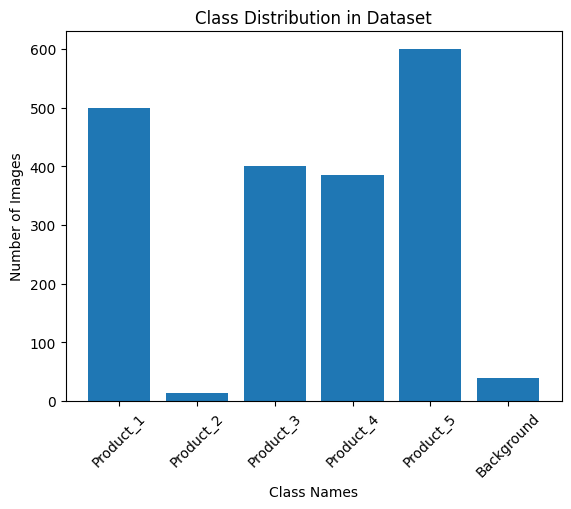

In [12]:
# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xticks(rotation=45)
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

Preprocessing with Augmentation for Imbalanced Classes

In [13]:
# Data preprocessing
image_size = (128, 128)  # Resize all images to this size
X = []
y = []

In [14]:
# Define a function for data augmentation
def augment_image(image):
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode="nearest",
    )
  image = image.reshape((1, *image_size, 3))
  augmented_images = [datagen.flow(image, batch_size=1).next()[0].astype(np.uint8) for _ in range(5)]
  return augmented_images

In [15]:
# Load and augment images
for label, class_name in enumerate(class_distribution.keys()):
  class_dir = os.path.join(dataset_path, class_name)
  for file_name in os.listdir(class_dir):
    file_path = os.path.join(class_dir, file_name)
    try:
      # Load image
      image = cv2.imread(file_path)
      image = cv2.resize(image, image_size)  # Resize image
      X.append(image)
      y.append(label)

      # Augment underrepresented classes
      if class_name in ['Product_2', 'Background'] and len(X) < 200:
        augmented_images = augment_image(image)
        X.extend(augmented_images)
        y.extend([label] * len(augmented_images))
    except Exception as e:
      print(f"Error loading {file_name}: {e}")

In [16]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [17]:
# Normalize pixel values
X = X / 255.0

In [18]:
# One-hot encode labels
y = to_categorical(y)

In [19]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [20]:
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

Training data: (1356, 128, 128, 3), (1356, 6)
Validation data: (291, 128, 128, 3), (291, 6)
Test data: (291, 128, 128, 3), (291, 6)


#**CNN MODEL**

In [21]:
# Define CNN model
cnn_model = Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
#model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

We are using 20 epochs to give the models enough training cycles to learn effectively while avoiding overfitting.

Early stopping was used to stop training if no improvement was observed, ensuring efficient use of resources.

In [25]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4118 - loss: 1.4021 - val_accuracy: 0.8488 - val_loss: 0.4060
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8494 - loss: 0.4688 - val_accuracy: 0.9347 - val_loss: 0.2244
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8947 - loss: 0.3592 - val_accuracy: 0.9656 - val_loss: 0.1319
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9238 - loss: 0.2463 - val_accuracy: 0.9759 - val_loss: 0.0904
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9261 - loss: 0.2458 - val_accuracy: 0.9759 - val_loss: 0.0867
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9332 - loss: 0.1903 - val_accuracy: 0.9691 - val_loss: 0.1133
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9356 - loss: 0.1769 - val_accuracy: 0.9828 - val_loss: 0.0631
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9582 - loss: 0.1200 - val_accuracy: 0.9794 - val_loss:

In [26]:
 # Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9689 - loss: 0.1244
Test Accuracy: 0.96


#**Transfer Learning**

**Transfer Learning using pretrained model VGG16**

In [27]:
# Load pre-trained VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [28]:
# Freeze base model layers to retain pre-trained weights
base_model.trainable = False

In [29]:
# craeting model
transfer_model = Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

In [30]:
transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
# Compile the transfer learning model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
# TranferLearning model | Training
history_transfer = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 344s 8s/step - accuracy: 0.6216 - loss: 1.4381 - val_accuracy: 0.9588 - val_loss: 0.1630
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 404s 9s/step - accuracy: 0.9268 - loss: 0.2451 - val_accuracy: 0.9759 - val_loss: 0.0989
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 363s 8s/step - accuracy: 0.9531 - loss: 0.1688 - val_accuracy: 0.9656 - val_loss: 0.0966
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 346s 8s/step - accuracy: 0.9484 - loss: 0.1732 - val_accuracy: 0.9828 - val_loss: 0.0723
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.9586 - loss: 0.1253 - val_accuracy: 0.9794 - val_loss: 0.0545


In [33]:
# Evaluate the model on test data
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test, y_test)
print(f"Test Accuracy (Transfer Learning): {test_accuracy_transfer:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.9569 - loss: 0.1670
Test Accuracy (Transfer Learning): 0.96


Visualizing predictions for CNN Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step


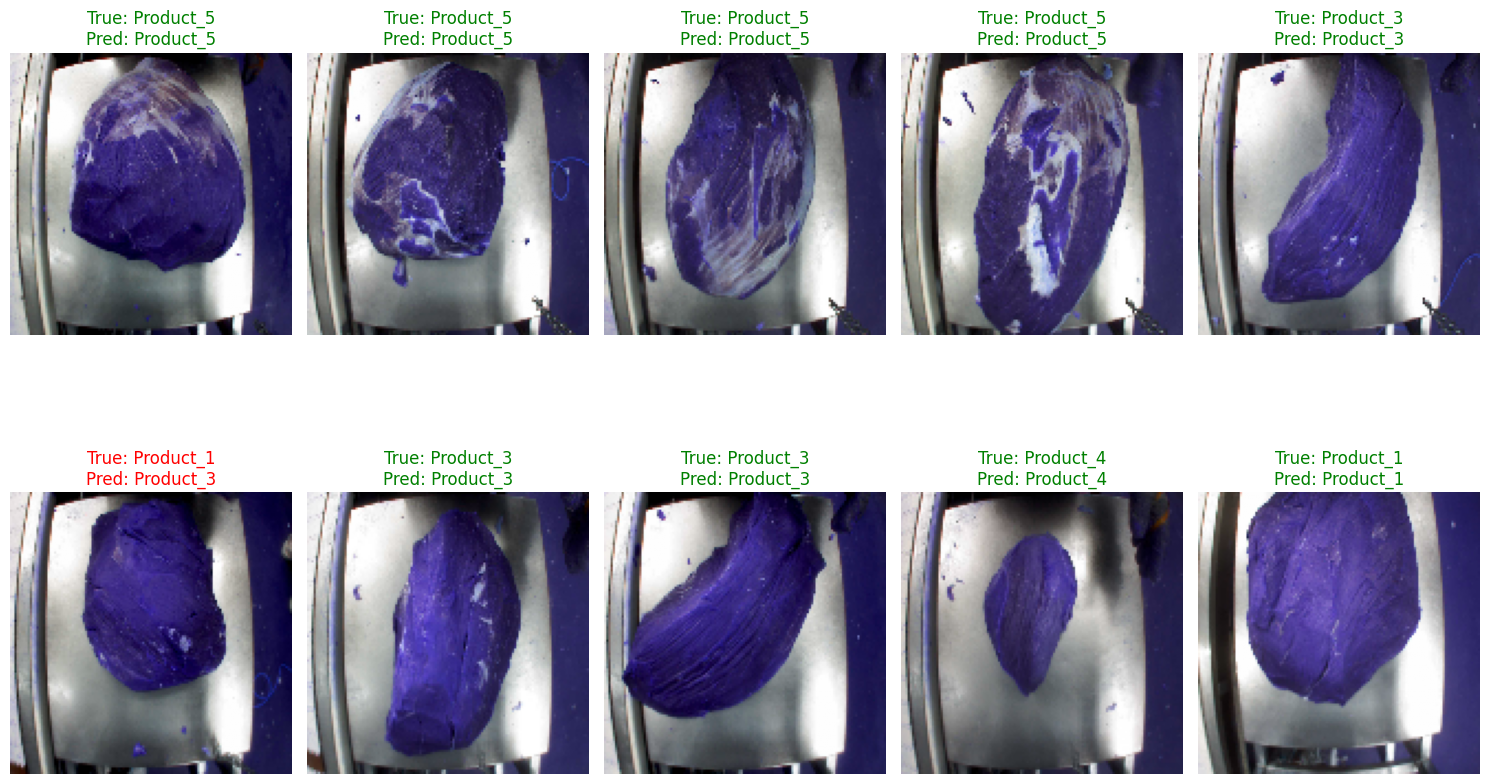

Visualizing predictions for Transfer Learning Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step


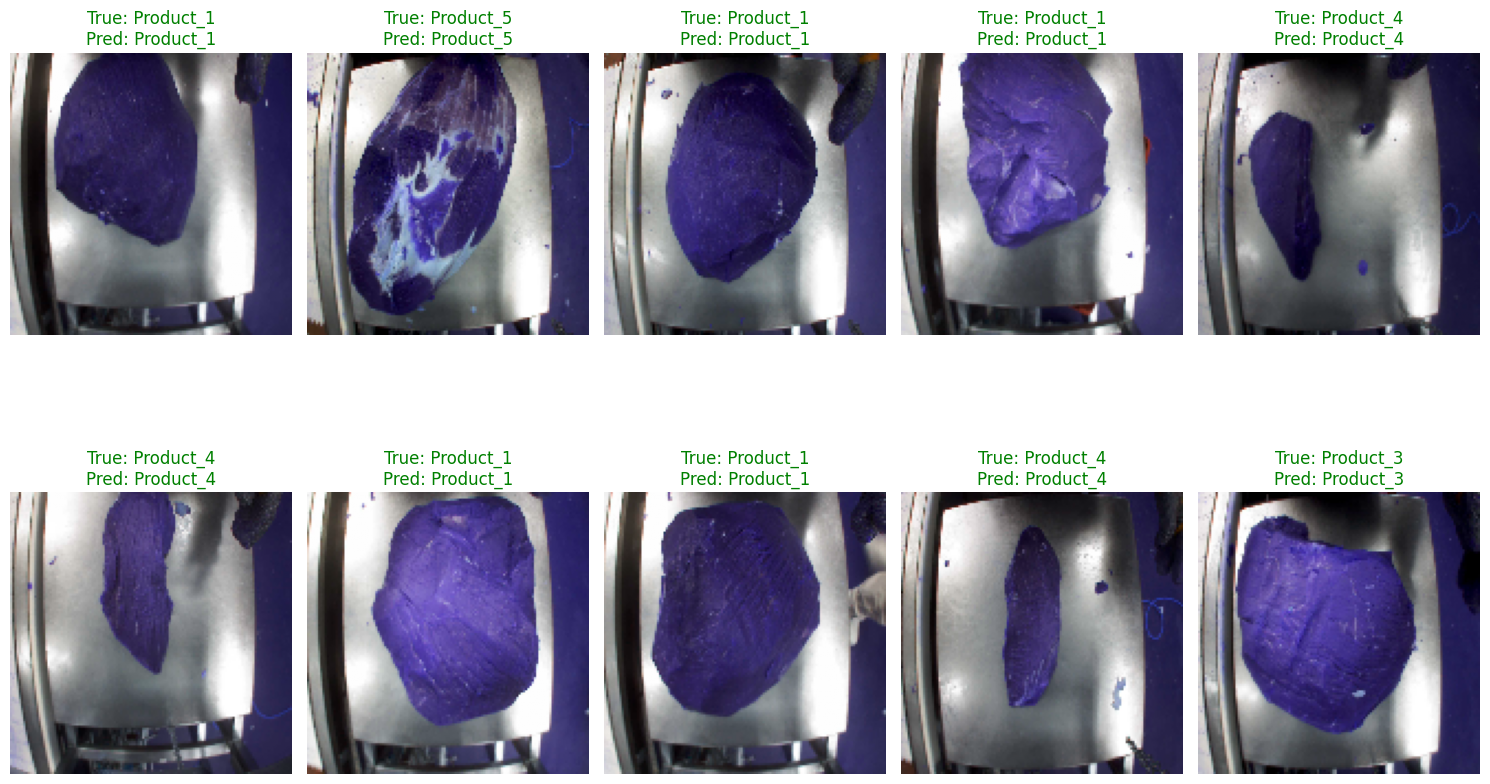

In [34]:
# Define a function to visualize predictions
def visualize_predictions(model, X_test, y_test, class_names, num_images=10):
  # Get predictions
  predictions = model.predict(X_test)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_test, axis=1)

  # Select random indices for visualization
  indices = np.random.choice(len(X_test), num_images, replace=False)

  plt.figure(figsize=(15, 10))
  for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    true_class = class_names[true_labels[idx]]
    predicted_class = class_names[predicted_labels[idx]]
    color = "green" if true_class == predicted_class else "red"
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
  plt.tight_layout()
  plt.show()

# Class names based on the dataset
class_names = list(class_distribution.keys())

# Visualize predictions for CNN Model
print("Visualizing predictions for CNN Model:")
visualize_predictions(cnn_model, X_test, y_test, class_names)

# Visualize predictions for Transfer Learning Model
print("Visualizing predictions for Transfer Learning Model:")
visualize_predictions(transfer_model, X_test, y_test, class_names)


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define function to compute metrics
def evaluate_model(model, X_test, y_test, class_names):
  # Get predictions
  predictions = model.predict(X_test)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_test, axis=1)

  # Classification report
  report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
  print("Classification Report:\n", report)

  # Confusion matrix
  conf_matrix = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

Metrics for CNN Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
Classification Report:
               precision    recall  f1-score   support

   Product_1     1.0000    0.8933    0.9437        75
   Product_2     0.0000    0.0000    0.0000         2
   Product_3     0.8788    0.9667    0.9206        60
   Product_4     1.0000    1.0000    1.0000        58
   Product_5     0.9574    1.0000    0.9783        90
  Background     1.0000    1.0000    1.0000         6

    accuracy                         0.9588       291
   macro avg     0.8060    0.8100    0.8071       291
weighted avg     0.9550    0.9588    0.9555       291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


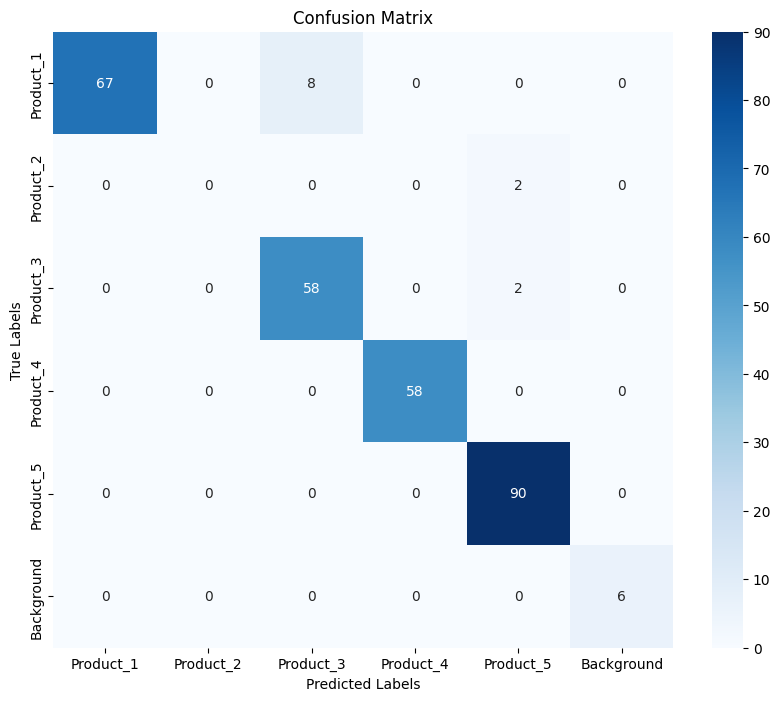

In [36]:
# Evaluate CNN Model
print("Metrics for CNN Model:")
evaluate_model(cnn_model, X_test, y_test, class_names)

Metrics for Transfer Learning Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

   Product_1     0.9600    0.9600    0.9600        75
   Product_2     0.0000    0.0000    0.0000         2
   Product_3     0.9464    0.8833    0.9138        60
   Product_4     1.0000    1.0000    1.0000        58
   Product_5     0.9375    1.0000    0.9677        90
  Background     1.0000    1.0000    1.0000         6

    accuracy                         0.9588       291
   macro avg     0.8073    0.8072    0.8069       291
weighted avg     0.9524    0.9588    0.9551       291



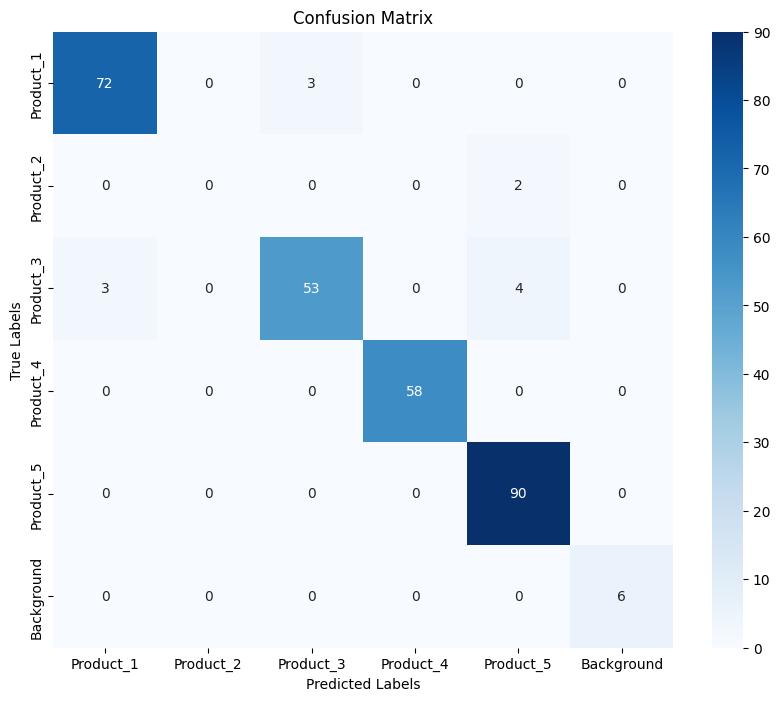

In [37]:
# Evaluate Transfer Learning Model
print("Metrics for Transfer Learning Model:")
evaluate_model(transfer_model, X_test, y_test, class_names)

#**Fine Tuning**

Here we used fine-tuning to adapt the pre-trained VGG16 model to the specific features of our dataset. Even though the accuracy was already high, fine-tuning allows the model to focus more on task-specific details, improving its performance on challenging classes like Product_2 and Background. This step also ensures alignment with the project requirements.

In [38]:
# Unfreezing top layers of the base model
base_model.trainable = True
for layer in base_model.layers[:15]:
  layer.trainable = False

# Recompile the model- lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Retraining the model
history_finetune = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 402s 9s/step - accuracy: 0.9317 - loss: 0.2145 - val_accuracy: 0.9759 - val_loss: 0.0983
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.9639 - loss: 0.1696 - val_accuracy: 0.9863 - val_loss: 0.0820
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 464s 10s/step - accuracy: 0.9640 - loss: 0.1205 - val_accuracy: 0.9794 - val_loss: 0.0775
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 420s 9s/step - accuracy: 0.9837 - loss: 0.0859 - val_accuracy: 0.9794 - val_loss: 0.0669
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 442s 9s/step - accuracy: 0.9840 - loss: 0.0718 - val_accuracy: 0.9794 - val_loss: 0.0674


In [39]:
# Evaluating the fine-tuned model on test data
test_loss_finetune, test_accuracy_finetune = transfer_model.evaluate(X_test, y_test)
print(f"Test Accuracy (Fine-Tuned Transfer Learning): {test_accuracy_finetune:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.9753 - loss: 0.1226
Test Accuracy (Fine-Tuned Transfer Learning): 0.97


Fine-tuning was performed after training the Transfer Learning model.

Some pre-trained layers were unfrozen to adapt features to the dataset.

This step refined the model's performance for task-specific patterns.

It ensured better alignment with the dataset and met project requirements.